
0: 480x640 1 person, 19 cars, 4 buss, 1 truck, 47.4ms
Speed: 1.3ms preprocess, 47.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 18 cars, 4 buss, 1 truck, 47.2ms
Speed: 0.8ms preprocess, 47.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 19 cars, 4 buss, 1 truck, 46.8ms
Speed: 1.1ms preprocess, 46.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 20 cars, 4 buss, 1 truck, 50.6ms
Speed: 1.1ms preprocess, 50.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 19 cars, 4 buss, 44.2ms
Speed: 1.1ms preprocess, 44.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 18 cars, 4 buss, 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 20 cars, 4 buss, 42.5ms
Speed: 1.0ms preprocess, 42.5ms inference, 0.6ms postprocess

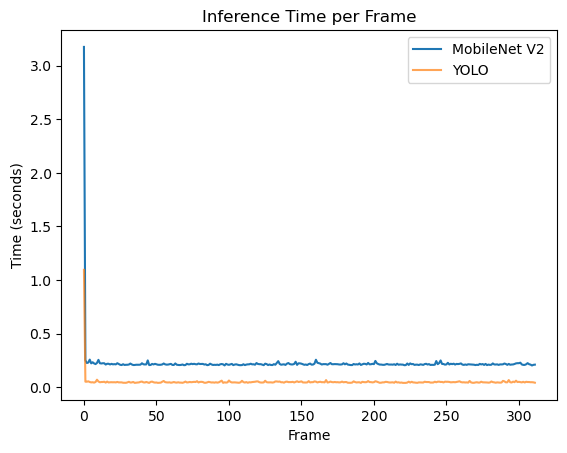

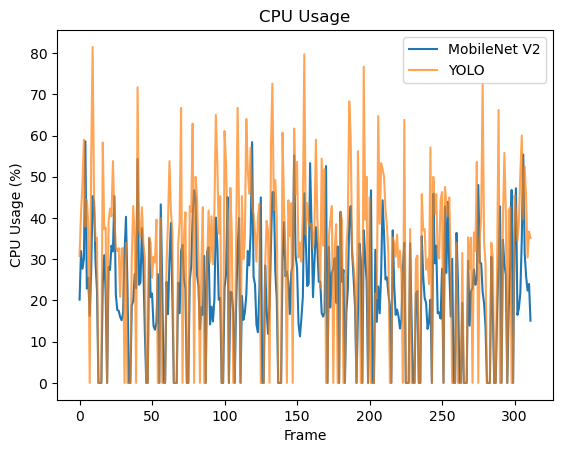

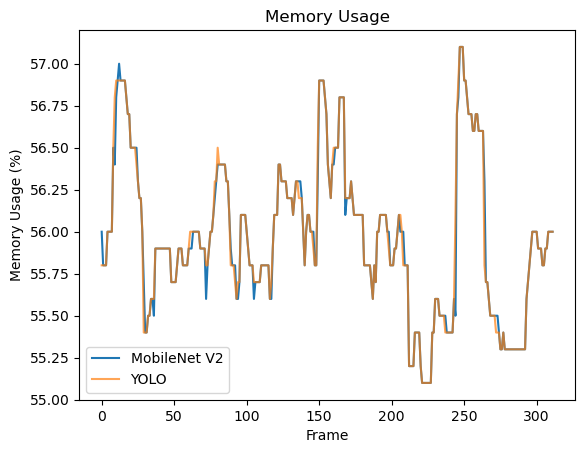

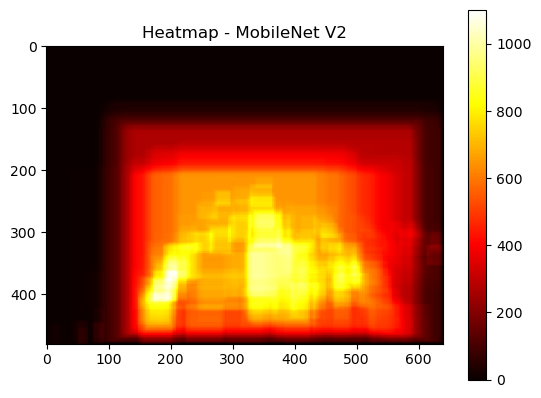

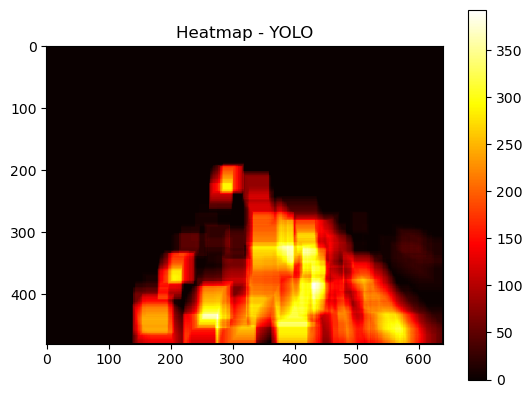

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from ultralytics import YOLO
import time
import psutil
import matplotlib.pyplot as plt

# Load the MobileNet V2 model
model_path = r"mobilenet_v2"
mobilenet_model = tf.saved_model.load(model_path)

yolo_model = YOLO('yolov8n.pt')

vehicle_classes = [1, 2, 3, 5, 7] 

def detect_objects_mobilenet(frame):
    input_tensor = tf.convert_to_tensor(np.expand_dims(frame, axis=0))
    detections = mobilenet_model(input_tensor)

    # Extract detection results
    boxes = detections['detection_boxes'][0].numpy()
    scores = detections['detection_scores'][0].numpy()
    return boxes, scores

def detect_vehicles_yolo(frame):
    results = yolo_model.predict(frame,verbose=False) 
    vehicle_boxes = []
    
    for result in results:
        for bbox, cls_id, conf in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
            if int(cls_id) in vehicle_classes and conf > 0.5:
                x1, y1, x2, y2 = map(int, bbox)
                vehicle_boxes.append([x1, y1, x2, y2])
    
    return vehicle_boxes

def generate_heatmap_mobilenet(frame, heatmap):
    boxes, scores = detect_objects_mobilenet(frame)
    
    for i in range(len(scores)):
        if scores[i] >= 0.5:
            box = boxes[i]
            (ymin, xmin, ymax, xmax) = box
            (left, right, top, bottom) = (xmin * frame.shape[1], xmax * frame.shape[1],
                                           ymin * frame.shape[0], ymax * frame.shape[0])
            heatmap[int(top):int(bottom), int(left):int(right)] += 1
    
    return heatmap

def generate_heatmap_yolo(frame, heatmap):
    vehicle_boxes = detect_vehicles_yolo(frame)
    
    for (x1, y1, x2, y2) in vehicle_boxes:
        heatmap[y1:y2, x1:x2] += 1
    
    return heatmap,vehicle_boxes

def process_video(PATHH):
    cap = cv2.VideoCapture(PATHH)
    
    heatmap_mobilenet = np.zeros((480, 640), dtype=np.float32)
    heatmap_yolo = np.zeros((480, 640), dtype=np.float32)
    
    inference_times_mobilenet = []
    inference_times_yolo = []
    
    cpu_usage_mobilenet = []
    cpu_usage_yolo = []
    
    mem_usage_mobilenet = []
    mem_usage_yolo = []
    
    ret, frame = cap.read()
    if not ret:
        print("Failed to read video")
        return
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_resized = cv2.resize(frame, (640, 480))

        start_time = time.time()
        heatmap_mobilenet = generate_heatmap_mobilenet(frame_resized, heatmap_mobilenet)
        inference_time = time.time() - start_time
        inference_times_mobilenet.append(inference_time)

        cpu_usage_mobilenet.append(psutil.cpu_percent())
        mem_usage_mobilenet.append(psutil.virtual_memory().percent)

        start_time = time.time()
        heatmap_yolo = generate_heatmap_yolo(frame_resized, heatmap_yolo)
        inference_time = time.time() - start_time
        inference_times_yolo.append(inference_time)

        cpu_usage_yolo.append(psutil.cpu_percent())
        mem_usage_yolo.append(psutil.virtual_memory().percent)

    cap.release()

    return (inference_times_mobilenet, inference_times_yolo,
            cpu_usage_mobilenet, cpu_usage_yolo,
            mem_usage_mobilenet, mem_usage_yolo,
            heatmap_mobilenet, heatmap_yolo)


inference_times_mobilenet, inference_times_yolo, \
cpu_usage_mobilenet, cpu_usage_yolo, \
mem_usage_mobilenet, mem_usage_yolo, \
heatmap_mobilenet, heatmap_yolo = process_video('video.mp4')


plt.figure()
plt.plot(inference_times_mobilenet, label='MobileNet V2')
plt.plot(inference_times_yolo, label='YOLO', alpha=0.7)
plt.title('Inference Time per Frame')
plt.xlabel('Frame')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()

plt.figure()
plt.plot(cpu_usage_mobilenet, label='MobileNet V2')
plt.plot(cpu_usage_yolo, label='YOLO', alpha=0.7)
plt.title('CPU Usage')
plt.xlabel('Frame')
plt.ylabel('CPU Usage (%)')
plt.legend()
plt.show()

plt.figure()
plt.plot(mem_usage_mobilenet, label='MobileNet V2')
plt.plot(mem_usage_yolo, label='YOLO', alpha=0.7)
plt.title('Memory Usage')
plt.xlabel('Frame')
plt.ylabel('Memory Usage (%)')
plt.legend()
plt.show()

plt.figure()
plt.title('Heatmap - MobileNet V2')
plt.imshow(heatmap_mobilenet, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Heatmap - YOLO')
plt.imshow(heatmap_yolo, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()


In [7]:
import tensorflow as tf
import torch
import cv2
import numpy as np
import time
import psutil
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [22]:
model_path = r"mobilenet_v2"
mobilenet_model = tf.saved_model.load(model_path)

yolo_model = YOLO('yolov8n.pt') 
vehicle_classes = [1, 2, 3, 5, 7] 


In [32]:
def set_tf_device(device='GPU'):
    if device == 'GPU' and tf.config.list_physical_devices('GPU'):
        tf.config.set_logical_device_configuration(
            tf.config.list_physical_devices('GPU')[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])  # Adjust memory limit based on requirement
    elif device == 'CPU':
        tf.config.set_visible_devices([], 'GPU')  # Only CPU will be visible

def set_yolo_device(device='GPU'):
    if device == 'GPU':
        yolo_model.to('cuda') if torch.cuda.is_available() else yolo_model.to('mps')
    elif device == 'CPU':
        yolo_model.to('cpu')

# Set the devices at the beginning of the script
def setup_devices(device='GPU'):
    # Set up TensorFlow device
    set_tf_device(device)
    
    # Set up YOLO device
    set_yolo_device(device)


In [33]:


def detect_objects_mobilenet(frame):
    input_tensor = tf.convert_to_tensor(np.expand_dims(frame, axis=0))
    detections = mobilenet_model(input_tensor)

    # Extract detection results
    boxes = detections['detection_boxes'][0].numpy()
    scores = detections['detection_scores'][0].numpy()
    return boxes, scores


In [34]:
def detect_vehicles_yolo(frame):
    results = yolo_model.predict(frame,verbose=False) 
    vehicle_boxes = []
    
    for result in results:
        for bbox, cls_id, conf in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
            if int(cls_id) in vehicle_classes and conf > 0.5:
                x1, y1, x2, y2 = map(int, bbox)
                vehicle_boxes.append([x1, y1, x2, y2])
    
    return vehicle_boxes

In [35]:

def generate_heatmap_mobilenet(frame, heatmap):
    boxes, scores = detect_objects_mobilenet(frame)
    
    for i in range(len(scores)):
        if scores[i] >= 0.5:
            box = boxes[i]
            (ymin, xmin, ymax, xmax) = box
            (left, right, top, bottom) = (xmin * frame.shape[1], xmax * frame.shape[1],
                                           ymin * frame.shape[0], ymax * frame.shape[0])
            heatmap[int(top):int(bottom), int(left):int(right)] += 1
    
    return heatmap

In [36]:
def generate_heatmap_yolo(frame, heatmap):
    vehicle_boxes = detect_vehicles_yolo(frame)
    
    for (x1, y1, x2, y2) in vehicle_boxes:
        heatmap[y1:y2, x1:x2] += 1
    
    return heatmap

In [27]:

def set_tf_device(device='GPU'):
    if device == 'GPU' and tf.config.list_physical_devices('GPU'):
        tf.config.set_logical_device_configuration(
            tf.config.list_physical_devices('GPU')[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])  # Adjust memory limit based on requirement
    elif device == 'CPU':
        tf.config.set_visible_devices([], 'GPU')  # Only CPU will be visible

def set_yolo_device(device='GPU'):
    if device == 'GPU':
        yolo_model.to('cuda') if torch.cuda.is_available() else yolo_model.to('mps')
    elif device == 'CPU':
        yolo_model.to('cpu')

In [39]:
def process_video(PATHH, device='GPU'):
    # Set the devices
    # set_tf_device(device)
    # set_yolo_device(device)
    setup_devices(device)
    
    cap = cv2.VideoCapture(PATHH)
    
    heatmap_mobilenet = np.zeros((480, 640), dtype=np.float32)
    heatmap_yolo = np.zeros((480, 640), dtype=np.float32)
    
    inference_times_mobilenet = []
    inference_times_yolo = []
    
    cpu_usage_mobilenet = []
    cpu_usage_yolo = []
    
    mem_usage_mobilenet = []
    mem_usage_yolo = []
    
    ret, frame = cap.read()
    if not ret:
        print("Failed to read video")
        return
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_resized = cv2.resize(frame, (640, 480))

        # Run MobileNet
        start_time = time.time()
        heatmap_mobilenet = generate_heatmap_mobilenet(frame_resized, heatmap_mobilenet)
        inference_time = time.time() - start_time
        inference_times_mobilenet.append(inference_time)

        cpu_usage_mobilenet.append(psutil.cpu_percent())
        mem_usage_mobilenet.append(psutil.virtual_memory().percent)

        # Run YOLO
        start_time = time.time()
        heatmap_yolo = generate_heatmap_yolo(frame_resized, heatmap_yolo)
        inference_time = time.time() - start_time
        inference_times_yolo.append(inference_time)

        cpu_usage_yolo.append(psutil.cpu_percent())
        mem_usage_yolo.append(psutil.virtual_memory().percent)

    cap.release()

    return (inference_times_mobilenet, inference_times_yolo,
            cpu_usage_mobilenet, cpu_usage_yolo,
            mem_usage_mobilenet, mem_usage_yolo,
            heatmap_mobilenet, heatmap_yolo)


In [40]:
results = {
    'GPU': {},
    'CPU': {},
}

In [41]:
for device in ['CPU']:
    print(f"\nRunning models in {device} mode...\n")
    results[device]['inference_times_mobilenet'], results[device]['inference_times_yolo'], \
    results[device]['cpu_usage_mobilenet'], results[device]['cpu_usage_yolo'], \
    results[device]['mem_usage_mobilenet'], results[device]['mem_usage_yolo'], \
    results[device]['heatmap_mobilenet'], results[device]['heatmap_yolo'] = process_video('video.mp4', device=device)



Running models in CPU mode...



RuntimeError: Visible devices cannot be modified after being initialized